# Simulation of Feedback with Chaotic Dynamics from a Kawasaki Ising Model

In [208]:
import numpy as np
import random
from fractions import Fraction
from Commands import dec2int, bernoulli, control, order_parameter
from MonteCarloCommands import energy, boltzmann_probability
import matplotlib.pyplot as plt




## Initialization of Parameters

In [209]:

length = 100
random.seed(10)
times = 5
low_prob = 00
high_prob = 100 + 1
Beta = 0
K = 1 
num_chains = 2
spacing = 10
num_points = int(np.ceil((high_prob-low_prob)/spacing))




## Initialization of Order Parameter Arrays

In [210]:
if (length**2//2) % 10 == 0:
#record = np.zeros([high_prob-low_prob, 1], dtype=float)
    time_size = (length**2)//200+1 # number of data points along the time axis

    record1 = np.zeros([num_points, time_size], dtype=float) #[probability, time]
    record2 = np.zeros([num_points, time_size], dtype=float)
    recordferro = np.zeros([num_points,time_size], dtype=float) # set up for ferromagnetic order parameter
    #record3 = np.zeros([high_prob-low_prob, 1], dtype=float)
    recordlong = np.zeros((num_points, length, time_size), dtype=float) #[probability, position, time]
    staggeredMagnetization = np.zeros((num_points,time_size), dtype=float)
    totalparam = np.zeros((num_points,time_size))
    totrecordlong = np.zeros((num_points, time_size))
    
else: 
    time_size = (length**2)//200+2 # number of data points along the time axis

    record1 = np.zeros([num_points, time_size], dtype=float) #[probability, time]
    record2 = np.zeros([num_points, time_size], dtype=float)
    recordferro = np.zeros([num_points,time_size], dtype=float) # set up for ferromagnetic order parameter
    #record3 = np.zeros([high_prob-low_prob, 1], dtype=float)
    recordlong = np.zeros((num_points, length, time_size), dtype=float)
    staggeredMagnetization = np.zeros((num_points,time_size), dtype=float)
    totalparam = np.zeros((num_points,time_size))
    totrecordlong = np.zeros((num_points, time_size))


## Control + Kawasaki

In [211]:

for k in range(0, times):
    j = 0
    print(k)
    # Probability of choosing the Control Map
    for prob in range(low_prob, high_prob, spacing):
        #print(prob)
        #number1 = random.random()
        #number2 = random.random()
        #number3 = random.random()
        #number = tests[k]
        rep1 = random.getrandbits(length)
        rep2 = random.getrandbits(length)
        #rep3 = dec2int(number3, length)
        #print(k, rep, dec2int(Fraction(2, 3), length), dec2int(Fraction(1, 3), length))
        for i in range((length**2)//2):
            if random.random() > (float(prob) / 100):
                rep1 = bernoulli(rep1, length)
            else:
                rep1 = control(rep1, length)
            if random.random() > (float(prob)/100):
                rep2 = bernoulli(rep2, length)
            else:
                rep2 = control(rep2, length)
            #if random.random() > (float(prob)/100):
            #    rep3 = bernoulli(rep3, length)
            #else:
            #    rep3 = control(rep3, length)
            if (i%100)==0 and i !=0 and i != (length**2)//2:
                record1[j, i//100] += order_parameter(rep1, length)/times
                record2[j, i//100] += order_parameter(rep2, length)/times
                recordferro[j, i//100] += np.abs((lattice[0].count('1')+lattice[1].count('1')-lattice[0].count('0')-lattice[1].count('0'))/(2*length)/times)
                #record3[j] += order_parameter(rep3, length)/times
                for y in range(length):
                    for x in range(num_chains):
                        staggeredMagnetization[j, i//100] += (-1)**(x+y+~int(lattice[x][y]))/(2*length*times)
                for place in range(length):
                    recordlong[j,place, i//100] += order_parameter(int(lattice[0][length-1-place] +lattice[1][length-1-place] 
                                    , base=2),2)/times

            # Initializing Ising Array for Monte Carlo Simulation
            lattice = [format(rep1, '0'+str(length)+'b'), format(rep2, '0'+str(length)+'b')]
                       #format(rep3, '0'+str(length)+'b')]
            for repeat in range(1):
                for y_pos in range(0, length): # this section takes about 1/100 s at length = 100, accounts for most of the run time
                    for x_pos in range(0, num_chains):
                        E_i = energy(x_pos, y_pos, lattice, num_chains, length, K, True)
                        old = lattice[x_pos]
                        # noinspection PyTypeChecker
                        lattice[x_pos] = format(int(lattice[x_pos], base=2) ^ (1 << (length - y_pos - 1)), '0' + str(length) + 'b')
                        E_f = energy(x_pos, y_pos, lattice, num_chains, length, K, True)
                        if random.random() <= boltzmann_probability(E_i, E_f, Beta):
                            pass
                        else:
                            lattice[x_pos] = old
            

            
            rep1 = int(lattice[0], base=2)
            rep2 = int(lattice[1], base=2)
            #rep3 = int(lattice[2], base=2)
        #record[j] += (order_parameter(rep1, length)+order_parameter(rep2,length)+order_parameter(rep3, length))/(3*times) # can get rid of. just average the other three records in a plot
        record1[j, -1] += order_parameter(rep1, length)/times
        record2[j, -1] += order_parameter(rep2, length)/times
        recordferro[j, -1] += np.abs((lattice[0].count('1')+lattice[1].count('1')-lattice[0].count('0')-lattice[1].count('0'))/(2*length)/times)
        #record3[j] += order_parameter(rep3, length)/times
        for y in range(length):
            for x in range(num_chains):
                staggeredMagnetization[j, -1] += (-1)**(x+y+~int(lattice[x][y]))/(2*length*times)
        staggeredMagnetization = np.abs(staggeredMagnetization) # accounts for changes of sign between iterations
        for place in range(length):
            recordlong[j,place, -1] += order_parameter(int(lattice[0][length-1-place] +lattice[1][length-1-place] 
                              , base=2),2)/times
        totrecordlong = (np.sum(recordlong, axis=1)/(length))
        j += 1
        #print(j, number, rep, record[j])
        


0
1
2
3
4


In [212]:

#print( record1/3,  record2/3 , np.ndarray(np.sum(recordlong, axis=1)/(length*3)))
for i in range(num_points):
    for tau in range(time_size):
        totalparam[i, tau] = record1[i, tau]/3+record2[i, tau]/3 + (np.sum(recordlong, axis=1))[i, tau]/(length*3)

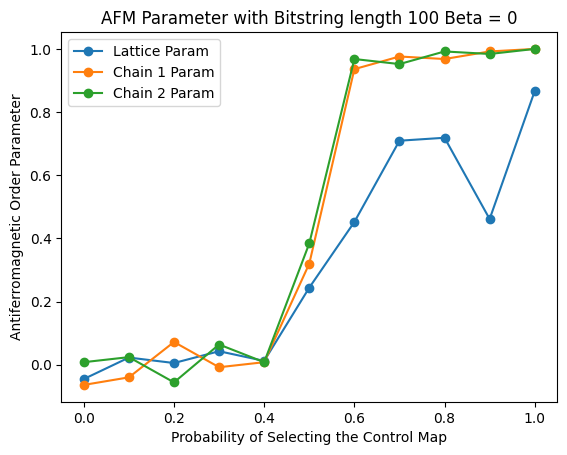

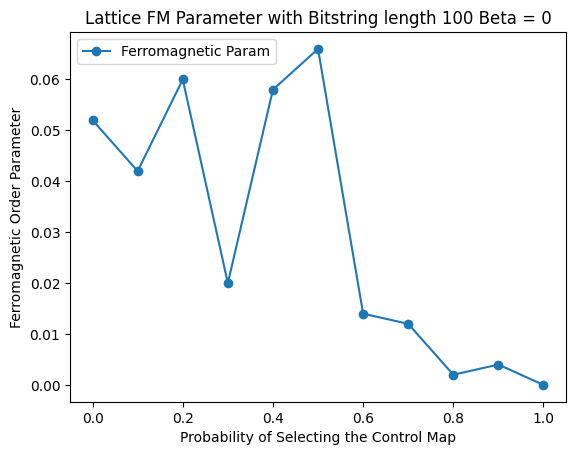

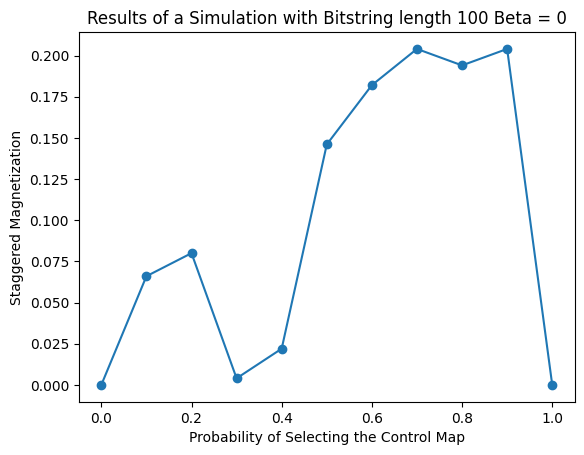

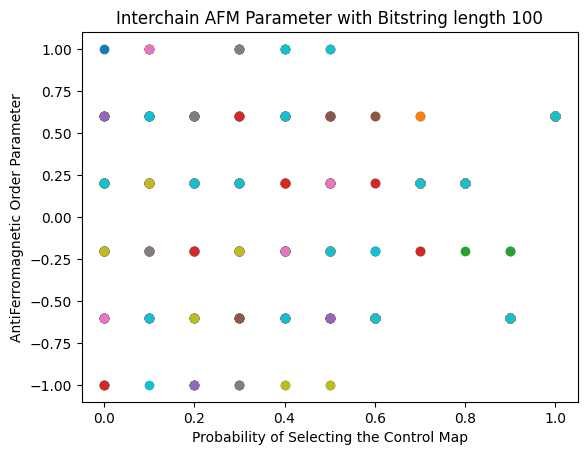

['0101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101', '0101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101']
1.0 1.0


In [213]:
plt.rcParams.update({
    "text.usetex": False,
})
#print(record[99])

fig, ax = plt.subplots() # results at end of simulation
ax.plot( np.linspace(0,1,num_points), totalparam[:,-1], marker='o', label="Lattice Param")

ax.plot( np.linspace(0,1,num_points), record1[:,-1], marker='o', label= "Chain 1 Param")
ax.plot( np.linspace(0,1,num_points), record2[:,-1], marker='o', label= "Chain 2 Param")

#Below creates two lines crossing at (.5,.5)
#plt.axvline(.5)
#plt.axhline(.5)

plt.legend(loc='upper left')
ax.set_xlabel(r'Probability of Selecting the Control Map')
ax.set_ylabel(r'Antiferromagnetic Order Parameter')
ax.set_title(r'AFM Parameter with Bitstring length '+str(length) +' Beta = ' +str(Beta))

fig, ax = plt.subplots() # results at end of simulation
ax.plot( np.linspace(0,1,num_points), np.abs(recordferro[:,-1]), marker='o', label= "Ferromagnetic Param")
plt.legend(loc='upper left')
ax.set_xlabel(r'Probability of Selecting the Control Map')
ax.set_ylabel(r'Ferromagnetic Order Parameter')
ax.set_title(r'Lattice FM Parameter with Bitstring length '+str(length) +' Beta = ' +str(Beta))

fig, ax = plt.subplots() # results at end of simulation
ax.plot(np.linspace(0,1,num_points), np.abs(staggeredMagnetization[:,-1]), marker='o', label = "Staggered Magnetization")
ax.set_xlabel(r'Probability of Selecting the Control Map')
ax.set_ylabel(r'Staggered Magnetization')
ax.set_title(r'Results of a Simulation with Bitstring length '+str(length) +' Beta = ' +str(Beta))

fig, ax = plt.subplots()
for p in range(length):
    ax.scatter( np.linspace(0,1,num_points), recordlong[:, p, -1], marker='o', label="Param Row =" + str(p))

ax.set_xlabel(r'Probability of Selecting the Control Map')
ax.set_ylabel(r'AntiFerromagnetic Order Parameter')
ax.set_title(r'Interchain AFM Parameter with Bitstring length '+str(length))
#fig.save("200 Length BitString, Full Probability Spectrum")
#plt.show()
#fig, ax = plt.subplots()
#ax.plot( np.linspace(.3,.6,30), record1[30:60], marker='o')
#ax.set_xlabel(r'Probability of Selecting the Control Map')
#ax.set_ylabel(r'$ <\hat{O}>$')
#ax.set_title(r'Results of a Simulation with Bitstring length '+str(length))
#fig.save("200 Length BitString, Full Probability Spectrum")
plt.show()
print(lattice)
#print(int(lattice[0], base = 2)-int(lattice[1], base = 2))
print(record1[-1,-1],  record2[-1,-1])

C:\Users\Joshua\AppData\Local\Temp\ipykernel_200844\4037680232.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', prop={'size':8})


Text(0.5, 1.0, 'Interchain AFM Parameter with Bitstring length 100')

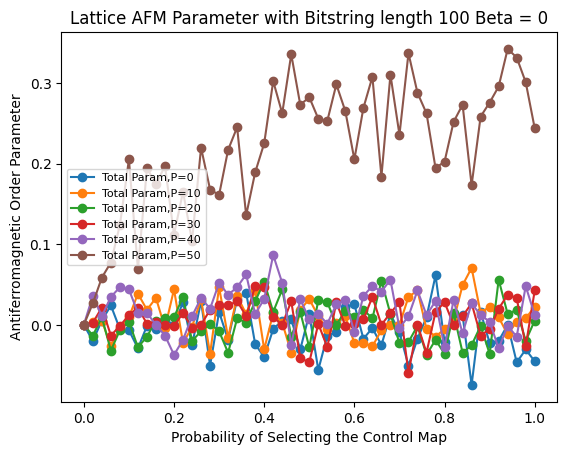

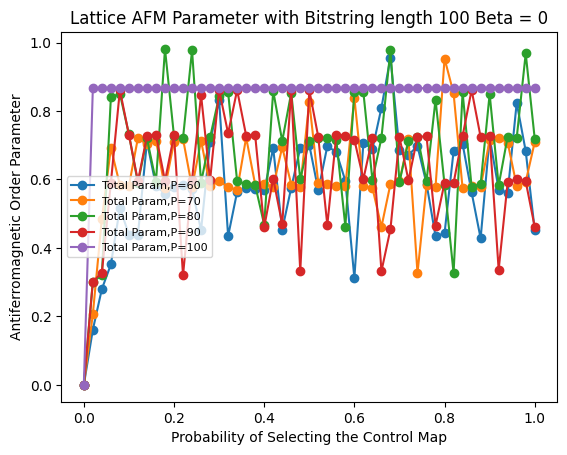

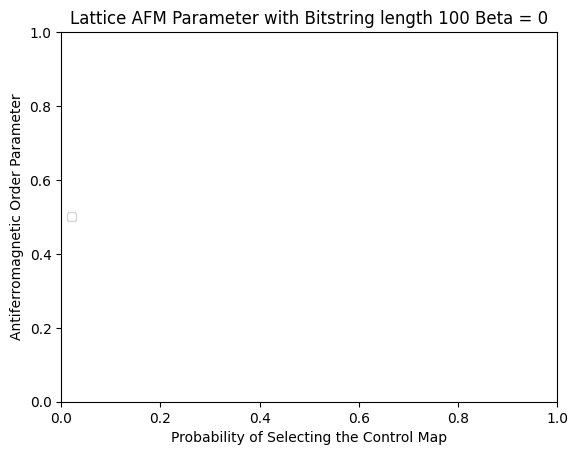

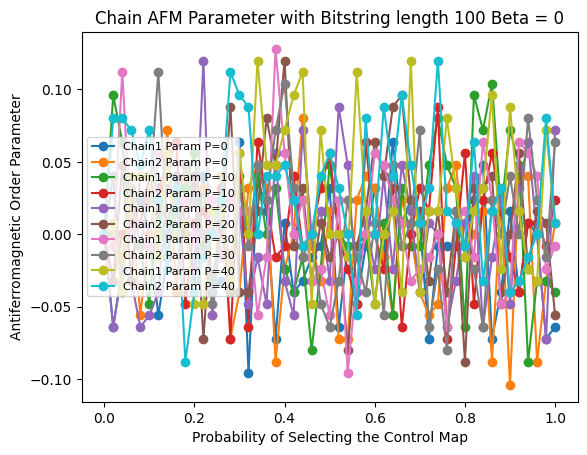

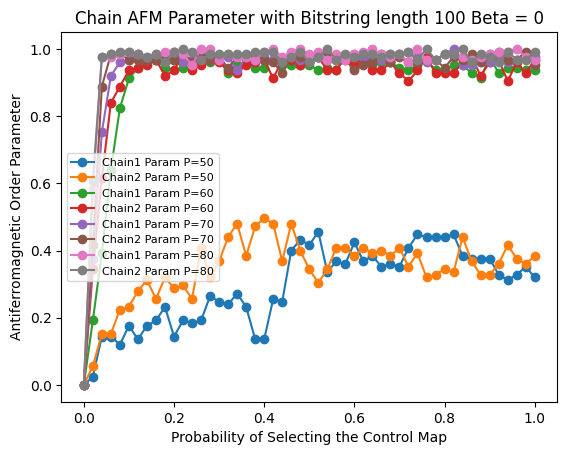

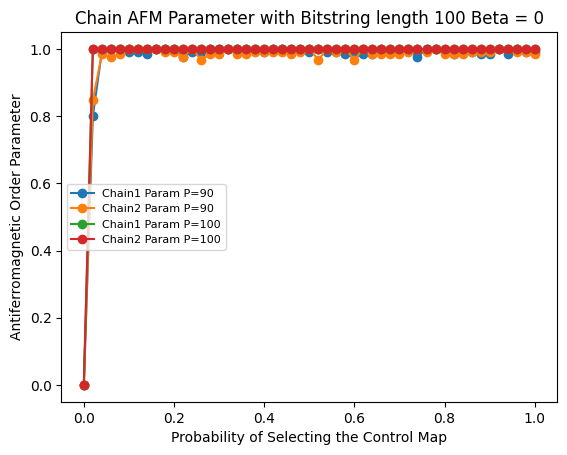

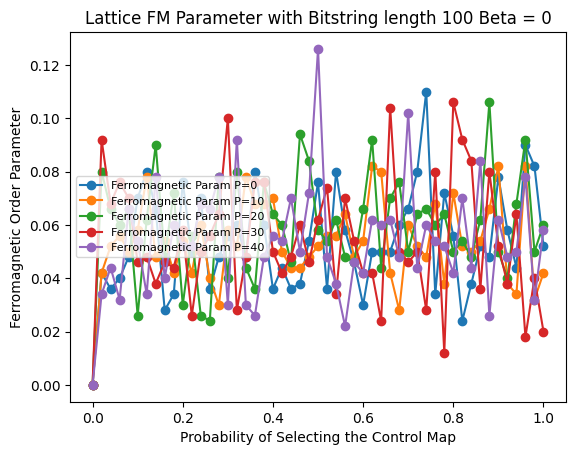

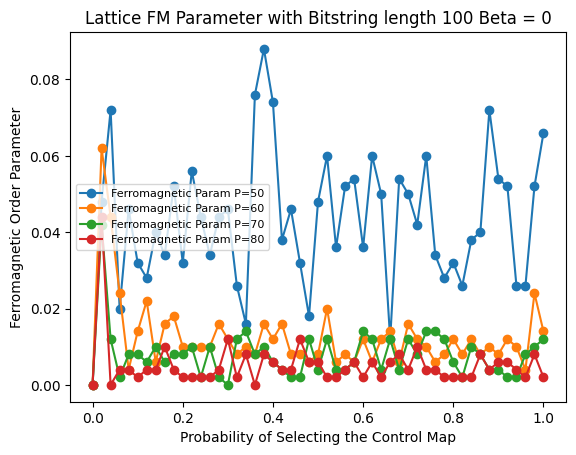

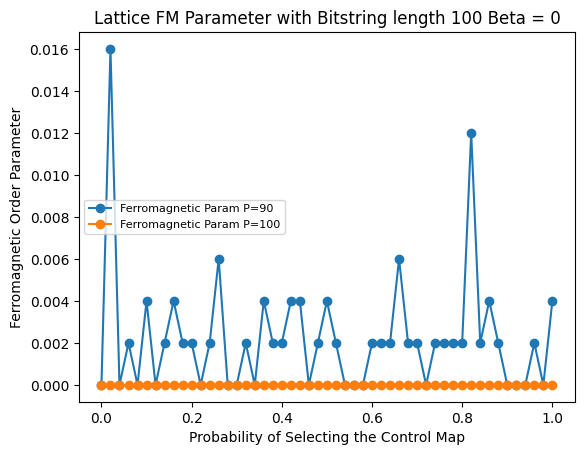

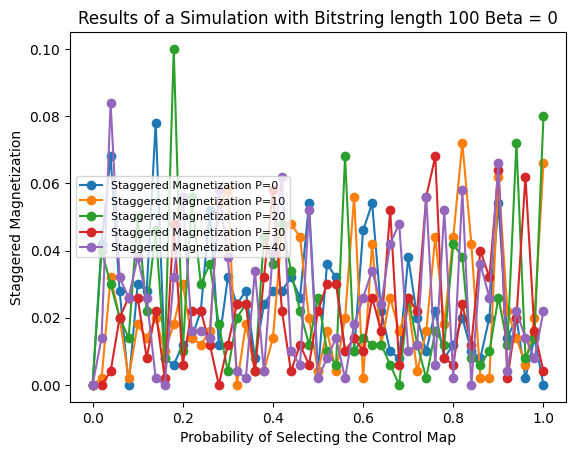

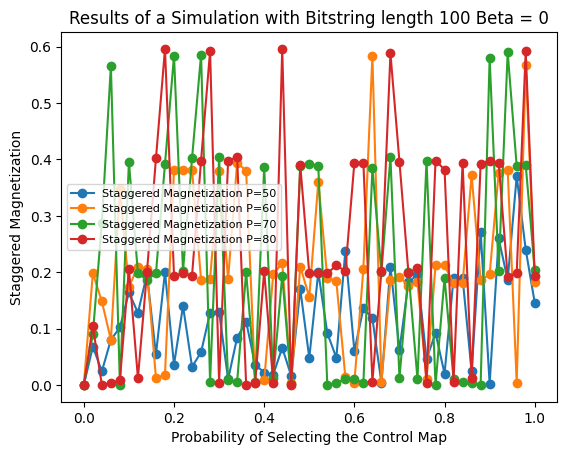

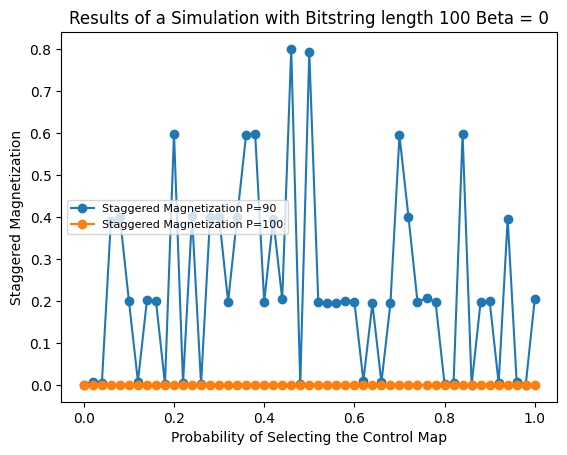

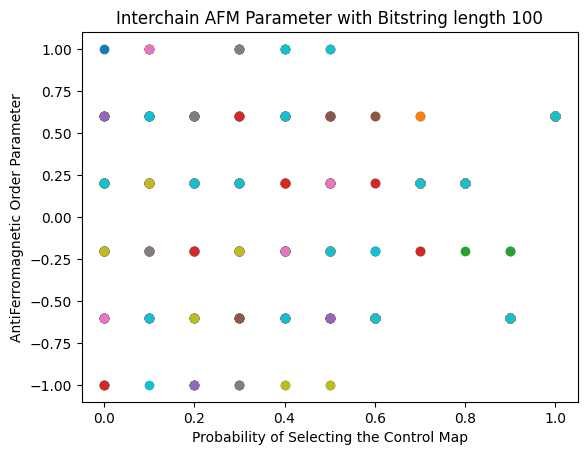

In [214]:
fig, ax = plt.subplots() 
for i in range(num_points):

    ax.plot( np.linspace(0,1,time_size), totalparam[i,:], marker='o', label="Total Param,P=" +str(i*spacing) )
    if i%5 == 0 and i!=0 and (i-1) != num_points: # for readability
        plt.legend(loc='center left', prop={'size':8})
        ax.set_xlabel(r'Probability of Selecting the Control Map')
        ax.set_ylabel(r'Antiferromagnetic Order Parameter')
        ax.set_title(r'Lattice AFM Parameter with Bitstring length '+str(length) +' Beta = ' +str(Beta))
        fig, ax = plt.subplots()

#Below creates two lines crossing at (.5,.5)
#plt.axvline(.5)
#plt.axhline(.5)

plt.legend(loc='center left', prop={'size':8})
ax.set_xlabel(r'Probability of Selecting the Control Map')
ax.set_ylabel(r'Antiferromagnetic Order Parameter')
ax.set_title(r'Lattice AFM Parameter with Bitstring length '+str(length) +' Beta = ' +str(Beta))

fig, ax = plt.subplots()
for i in range(num_points):

    ax.plot( np.linspace(0,1,time_size), record1[i,:], marker='o', label= "Chain1 Param P=" +str(i*spacing))
    ax.plot( np.linspace(0,1,time_size), record2[i,:], marker='o', label= "Chain2 Param P=" +str(i*spacing))
    if i%4 == 0 and i!=0 and (i-1) != num_points: # for readability
        plt.legend(loc='center left', prop={'size':8})
        ax.set_xlabel(r'Probability of Selecting the Control Map')
        ax.set_ylabel(r'Antiferromagnetic Order Parameter')
        ax.set_title(r'Chain AFM Parameter with Bitstring length '+str(length) +' Beta = ' +str(Beta))
        fig, ax = plt.subplots()

plt.legend(loc='center left', prop={'size':8})
ax.set_xlabel(r'Probability of Selecting the Control Map')
ax.set_ylabel(r'Antiferromagnetic Order Parameter')
ax.set_title(r'Chain AFM Parameter with Bitstring length '+str(length) +' Beta = ' +str(Beta))


fig, ax = plt.subplots()
for i in range(num_points):

    ax.plot( np.linspace(0,1,time_size), np.abs(recordferro[i,:]), marker='o', label= "Ferromagnetic Param P=" +str(i*spacing))
    if i%4 == 0 and i!=0 and (i-1) != num_points: # for readability
        plt.legend(loc='center left', prop={'size':8})
        ax.set_xlabel(r'Probability of Selecting the Control Map')
        ax.set_ylabel(r'Ferromagnetic Order Parameter')
        ax.set_title(r'Lattice FM Parameter with Bitstring length '+str(length) +' Beta = ' +str(Beta))
        fig, ax = plt.subplots()

plt.legend(loc='center left', prop={'size':8})
ax.set_xlabel(r'Probability of Selecting the Control Map')
ax.set_ylabel(r'Ferromagnetic Order Parameter')
ax.set_title(r'Lattice FM Parameter with Bitstring length '+str(length) +' Beta = ' +str(Beta))

fig, ax = plt.subplots()
for i in range(num_points):
    ax.plot(np.linspace(0,1, time_size), np.abs(staggeredMagnetization[i,:]), marker='o', label = "Staggered Magnetization P=" +str(i*spacing))
    if i%4 == 0 and i!=0 and (i-1) != num_points: # for readability
        plt.legend(loc='center left', prop={'size':8})
        ax.set_xlabel(r'Probability of Selecting the Control Map')
        ax.set_ylabel(r'Staggered Magnetization')
        ax.set_title(r'Results of a Simulation with Bitstring length '+str(length) +' Beta = ' +str(Beta))
        fig, ax = plt.subplots()

plt.legend(loc='center left', prop={'size':8})
ax.set_xlabel(r'Probability of Selecting the Control Map')
ax.set_ylabel(r'Staggered Magnetization')
ax.set_title(r'Results of a Simulation with Bitstring length '+str(length) +' Beta = ' +str(Beta))

fig, ax = plt.subplots()
for p in range(length):
    ax.scatter( np.linspace(0,1,num_points), recordlong[:, p, -1], marker='o', label="Param Row =" + str(p))

ax.set_xlabel(r'Probability of Selecting the Control Map')
ax.set_ylabel(r'AntiFerromagnetic Order Parameter')
ax.set_title(r'Interchain AFM Parameter with Bitstring length '+str(length))

Text(0.5, 1.0, 'Antiferromagnetic Order Parameter for the Lattice $\\beta$=0')

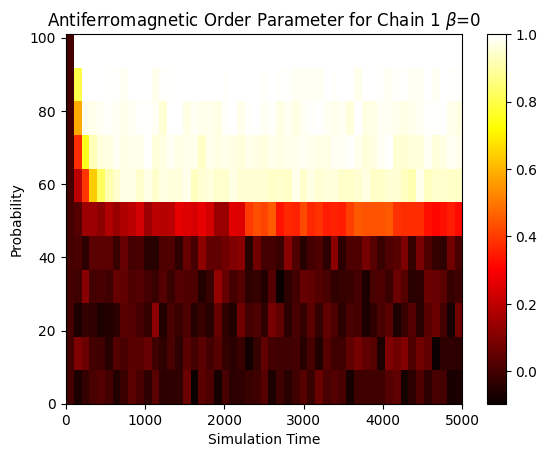

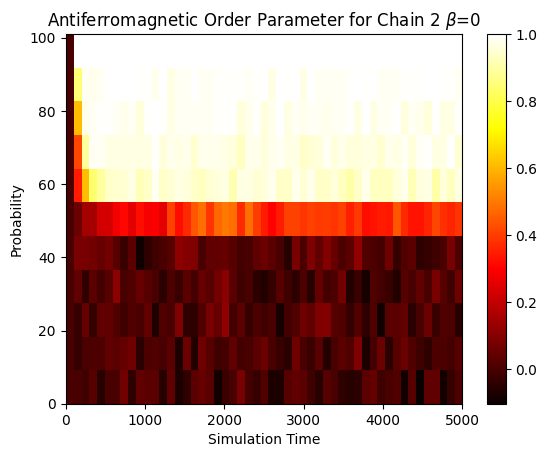

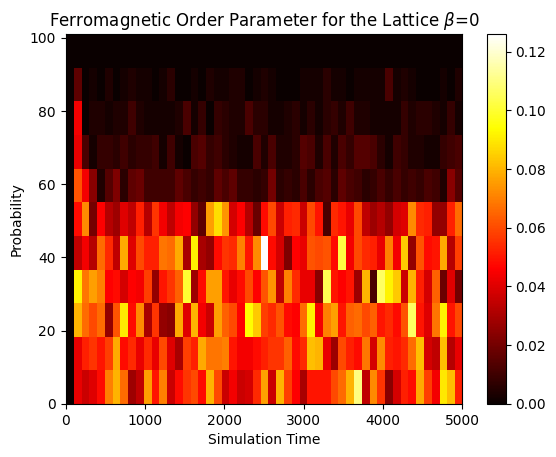

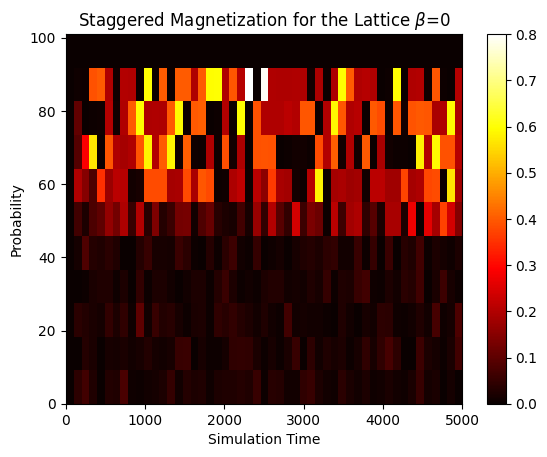

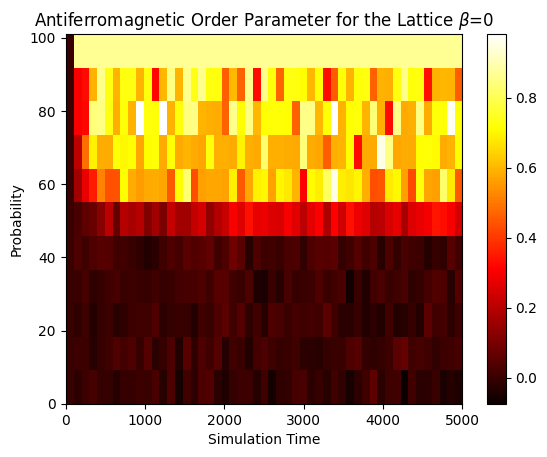

In [215]:

fig,ax = plt.subplots()
rec1=ax.imshow(record1, cmap='hot', interpolation='nearest', origin='lower', extent=[0,(length**2)//2,low_prob,high_prob], vmin=np.min(record1), vmax=np.max(record1), aspect='auto')
fig.colorbar(rec1, ax=ax, location ='right', shrink = 1)
ax.set_xlabel(r'Simulation Time')
ax.set_ylabel(r'Probability')
ax.set_title(r'Antiferromagnetic Order Parameter for Chain 1 $\beta$=' + str(Beta))

fig,ax = plt.subplots()
rec1=ax.imshow(record2, cmap='hot', interpolation='nearest', origin='lower', extent=[0,(length**2)//2,low_prob,high_prob],vmin=np.min(record2), vmax=np.max(record2), aspect='auto')
fig.colorbar(rec1, ax=ax, location ='right', shrink = 1)
ax.set_xlabel(r'Simulation Time')
ax.set_ylabel(r'Probability')
ax.set_title(r'Antiferromagnetic Order Parameter for Chain 2 $\beta$=' + str(Beta))


fig,ax = plt.subplots()
rec1=ax.imshow(recordferro, cmap='hot', interpolation='nearest', origin='lower', extent=[0,(length**2)//2,low_prob,high_prob],vmin=np.min(recordferro), vmax=np.max(recordferro), aspect='auto')
fig.colorbar(rec1, ax=ax, location ='right', shrink = 1)
ax.set_xlabel(r'Simulation Time')
ax.set_ylabel(r'Probability')
ax.set_title(r'Ferromagnetic Order Parameter for the Lattice $\beta$=' + str(Beta))


fig,ax = plt.subplots()
rec1=ax.imshow(staggeredMagnetization, cmap='hot', interpolation='nearest', origin='lower',extent=[0,(length**2)//2,low_prob,high_prob], vmin=np.min(staggeredMagnetization), vmax=np.max(staggeredMagnetization), aspect='auto')
fig.colorbar(rec1, ax=ax, location ='right', shrink = 1)
ax.set_xlabel(r'Simulation Time')
ax.set_ylabel(r'Probability')
ax.set_title(r'Staggered Magnetization for the Lattice $\beta$=' + str(Beta))


fig,ax = plt.subplots()
rec1=ax.imshow(totalparam,cmap = 'hot',interpolation='nearest', origin='lower', extent=[0,(length**2)//2,low_prob,high_prob],vmin=np.min(totalparam), vmax=np.max(totalparam), aspect='auto')
fig.colorbar(rec1, ax=ax, location ='right', shrink = 1)
ax.set_xlabel(r'Simulation Time')
ax.set_ylabel(r'Probability')
ax.set_title(r'Antiferromagnetic Order Parameter for the Lattice $\beta$=' + str(Beta))


In [216]:
print(totalparam[:,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
